# Importing Modules

In [0]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
#from autocorrect import spell
import string
from nltk.corpus import brown
from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Embedding, Dense, Flatten, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split

# Loading Data

In [0]:
train = pd.read_csv('prog_assign_train.tsv', delimiter='\t')

In [0]:
test = pd.read_csv('prog_assign_test.tsv', delimiter='\t')

In [0]:
train.shape, test.shape

((50000, 6), (5000, 3))

In [0]:
train.head()

,ID,Text,CharCount,Section,Class,Subclass
0,35067291,teaches the operating parameter signal contain...,112,A,1,D
1,35067293,teaches the operating parameter signal contain...,109,A,1,D
2,35072638,teaches the operating parameter signal contain...,109,A,1,D
3,35081117,an operating parameter detection arrangement t...,516,A,1,D
4,35081127,teaches the memory is arranged on the attached...,58,A,1,D


In [0]:
test.head()

,ID,Text,CharCount
0,45361187,"Therefore, at the time of the invention, it wo...",254
1,47925411,incumbent encryption scheme,28
2,47925414,to be received and stored at a VOD file server,47
3,47925427,selected packets with the non-selected packets,47
4,19831472,displaying a signal indicative of a corrective...,111


# Data Exploration

In [0]:
# Frequency of Classes Present
pd.value_counts(train['Section'])

G    10000
A    10000
C    10000
B    10000
H    10000
Name: Section, dtype: int64

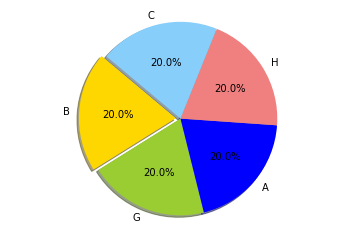

In [0]:
labels = 'B', 'G', 'A', 'H', 'C'
sizes = [pd.value_counts(train['Section'])['B'], pd.value_counts(train['Section'])['G'], pd.value_counts(train['Section'])['A'], pd.value_counts(train['Section'])['H'], pd.value_counts(train['Section'])['C']]
colors = ['gold', 'yellowgreen', 'blue', 'lightcoral', 'lightskyblue']
explode = (0.05, 0, 0, 0, 0)  


plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

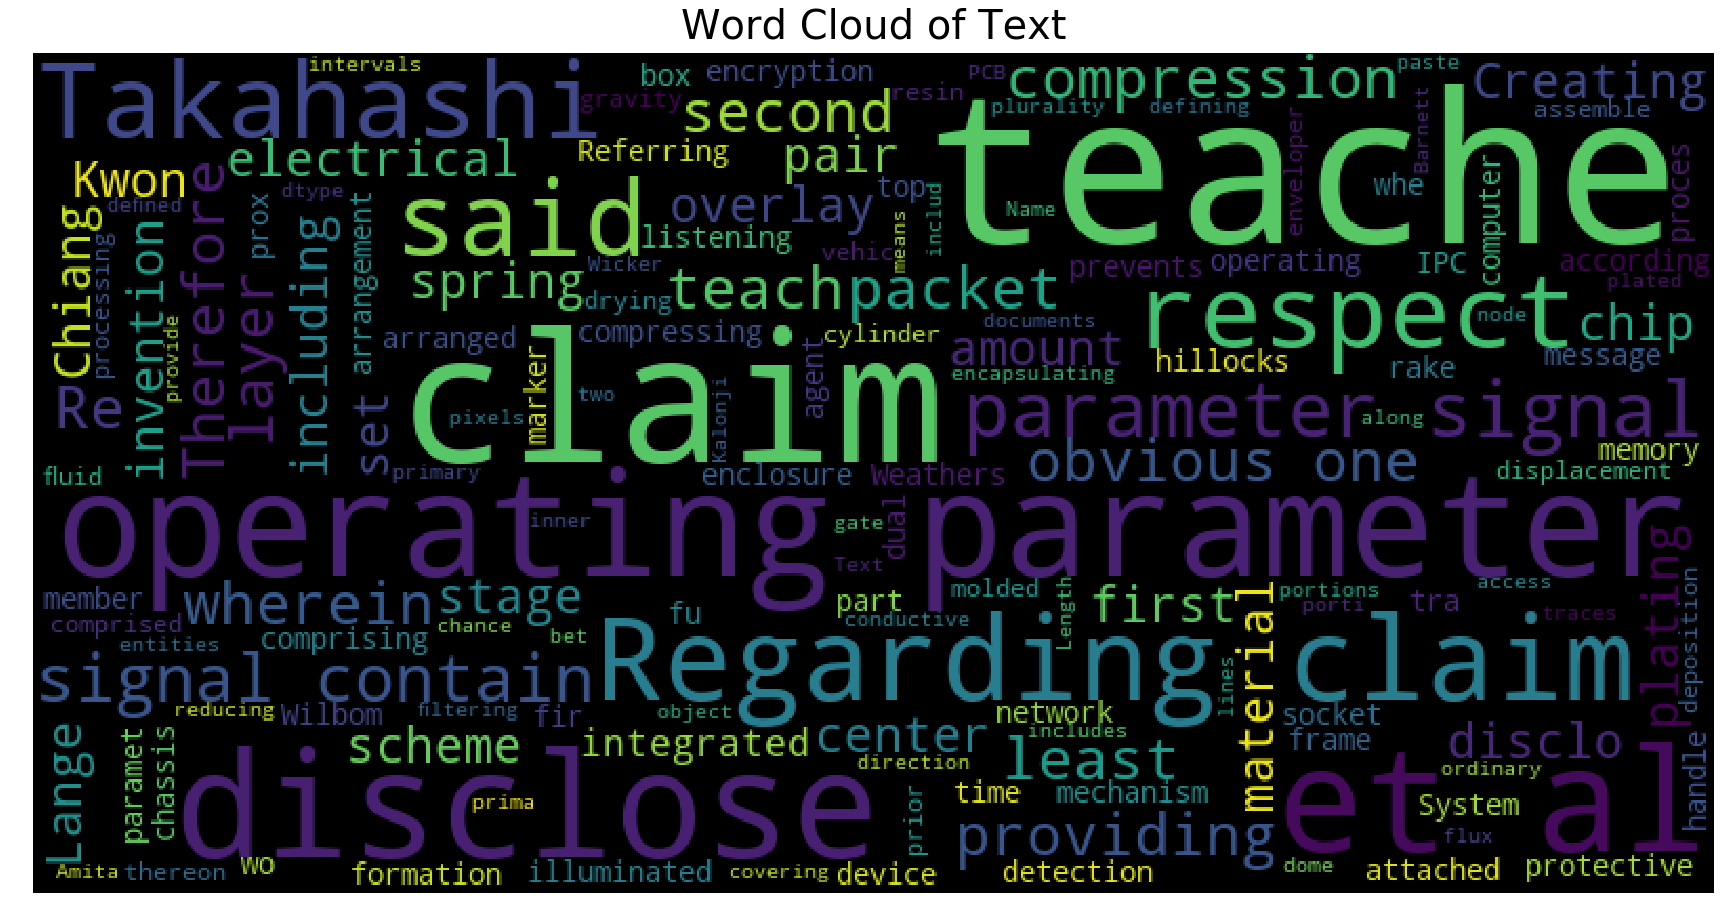

In [0]:
def wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
wordcloud(train["Text"], title="Word Cloud of Text")

In [0]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [0]:
word_list = brown.words()
word_set = set(word_list)
def spell_check(word):
    if word not in word_set:
        return spell(word)
    return word

### Spell Correction Code

**Will take too much time to run, so commenting it**

In [0]:
#train['text'] = train['Text']
#for row in range(train.shape[0]):
#    row_list = train['Text'][row].split()
#    correct_words = []
#    for word_index in range(len(row_list)):
#        correct_words.append(spell_check(row_list[word_index]))
#    train['text'][row] = ' '.join(correct_words)    

# N-gram Visualisation

In [0]:
train_H = train[train["Section"]=='H']
train_A = train[train["Section"]=='A']
train_G = train[train["Section"]=='G']
train_C = train[train["Section"]=='C']
train_B = train[train["Section"]=='B']

In [0]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [0]:
freq_dict = defaultdict(int)
for row in train["Text"]:
    for word in generate_ngrams(row):
        freq_dict[word] += 1
dict_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
dict_sorted.columns = ["word", "wordcount"]

Text(0, 0.5, 'Top Frequent Words')

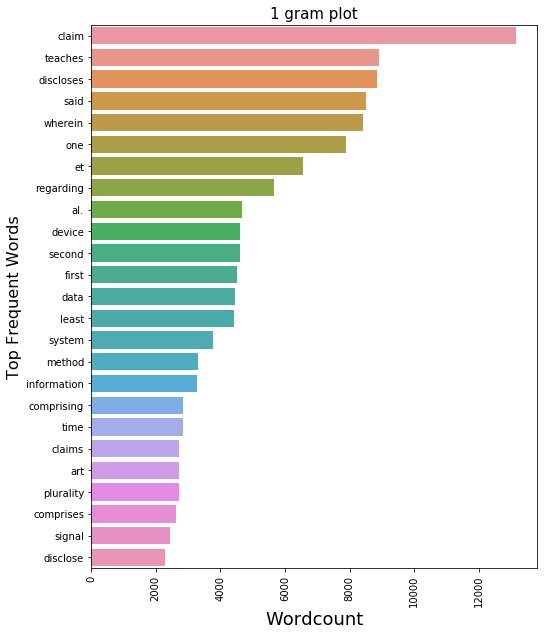

In [0]:
plt.figure(figsize = (8, 10))
g = sns.barplot(x = 'wordcount', y = 'word', data = dict_sorted.iloc[:25])
plt.xticks(rotation=90)
plt.title('1 gram plot', fontsize=15)
plt.xlabel('Wordcount', fontsize=18)
plt.ylabel('Top Frequent Words', fontsize=16)

In [0]:
freq_dict = defaultdict(int)
for row in train["Text"]:
    for word in generate_ngrams(row, 2):
        freq_dict[word] += 1
dict_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
dict_sorted.columns = ["word", "wordcount"]

Text(0, 0.5, 'Wordcount')

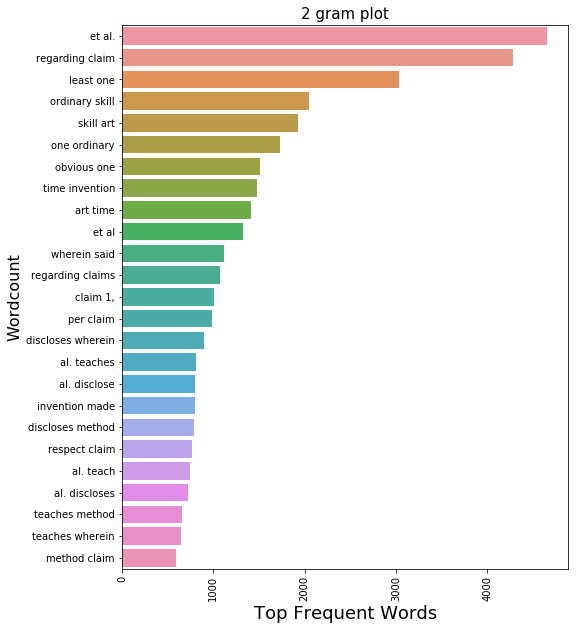

In [0]:
plt.figure(figsize = (8, 10))
g = sns.barplot(x = 'wordcount', y = 'word', data = dict_sorted.iloc[:25])
plt.xticks(rotation=90)
plt.title('2 gram plot', fontsize=15)
plt.xlabel('Top Frequent Words', fontsize=18)
plt.ylabel('Wordcount', fontsize=16)

# Data Cleaning

In [0]:
train["Text"] = train['Text'].str.replace('[^\w\s]','') # Removing Punctuations
train['Text'] = train['Text'].apply(lambda x: x.lower()) # Making Text Lowercase
stop = stopwords.words('english')  # Removing Stopwords
train['Text'] = train['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Stemming
train['Text'] = train["Text"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [0]:
test["Text"] = test['Text'].str.replace('[^\w\s]','') # Removing Punctuations
test['Text'] = test['Text'].apply(lambda x: x.lower()) # Making Text Lowercase
# Removing Stopwords
test['Text'] = test['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Stemming
test['Text'] = test["Text"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Feature Selection

In [0]:
# Selecting top 2000 frequent; The number of frequent words words has been choosen after data analysis
freq_words = [key for (key, count) in Counter(" ".join(train["Text"]).split()).most_common(2000)]
train['Text'] = train["Text"].apply(lambda x: ' '.join([word for word in x.split() if word in freq_words]))

## Creating Bag of Words Model

**Bag of words is a way of representing text data. First it creates a set of all the unique words in the entire corpus and then it creates a vector representation of all the training examples depending on the type of vectorizer**

Here, Count Vectorizer is used which stores the count of occurence of a word.

In [0]:
count = CountVectorizer()
bag_of_words = count.fit_transform(train['Text'].values)
X_train = bag_of_words.toarray()
y_train = train['Section']
X_test = count.fit_transform(train['Text'].values).toarray()

# Model Selection and Evaluation

**Here, I have selected random forest because it not only works well for multi-class classification problems but also it words exceptionally well when the data has high dimentionality**

**For model evaluation, GridSearchCV is used which looks at each potential combination of candidate values in the dictionary of parameters and outputs the best fitting parameter as per the cross validation score.**

Note that due saving computation time, I have take very less estimators. In Actual, 500-1000 estimators work well.

In [0]:
clf = RandomForestClassifier(
                         #   max_features='sqrt', 
                            #oob_score=True,
                            n_jobs=-1,
                            random_state=42
                            )
param_grid = {
                 'n_estimators': [200, 500],
                 'max_depth': [5, 10, 15]
             }
rf_clf = GridSearchCV(clf, param_grid, cv=5) # cv = 5 specifies the number of folds in a (Stratified)KFold.
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
best_parameters = rf_clf.best_params_  
print(best_parameters)  

{'max_depth': 15, 'n_estimators': 500}


## Fitting the best model

In [0]:
predictions = rf_clf.best_estimator_.predict(X_test)

# Dimensionality reduction using Linear Discriminant Analysis

Linear Discriminant Analysis is a dimensionality reduction technique which works very well on Text Data. It finds the lower dimensional projection of higher dimensional data which maximizes the class separation in he lower dimensional setup.

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=50)  # Number if n_components is a parameter to be tuned.
X_train_lda = lda.fit_transform(X_train, y_train)  
X_test_lda = lda.transform(X_test)

In [0]:
lda_clf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [5, 10, 15],
                 'max_depth': [2, 5, 7]
             }
lda_rf_clf = GridSearchCV(lda_clf, param_grid, cv=5) # cv = 5 specifies the number of folds in a (Stratified)KFold.
lda_rf_clf.fit(X_train_lda, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15], 'max_depth': [2, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
best_parameters = lda_rf_clf.best_params_  
print(best_parameters)  

{'max_depth': 7, 'n_estimators': 15}


In [0]:
predictions1 = rf_clf.best_estimator_.predict(X_test)

# Deep Learning Way

## One hot encoding the target values

In [0]:
le = LabelEncoder()
le_labels = le.fit_transform(y_train)
one_hot = OneHotEncoder(sparse=False)
reshaped_le_labels = le_labels.reshape((len(le_labels), 1))
target = one_hot.fit_transform(reshaped_le_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
tokenizer = Tokenizer(num_words=2000) # Again selecting 2000 features
tokenizer.fit_on_texts(train['Text'].values)
train_embeddings = tokenizer.texts_to_sequences(train['Text'].values)
test_embeddings = tokenizer.texts_to_sequences(test['Text'].values)
vocab_size = len(tokenizer.word_index) + 1

In [0]:
max_len = 20
embed_train = pad_sequences(train_embeddings, padding='post', maxlen=max_len)
embed_test = pad_sequences(test_embeddings, padding='post', maxlen=max_len)

In [0]:
embedding_dim = 25

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 25)            50025     
_________________________________________________________________
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
Total params: 55,090
Trainable params: 55,090
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_train, x_test, y_tr, y_te = train_test_split(embed_train, target, random_state = 42)

In [0]:
log_record = model.fit(x_train, y_tr,
                    epochs=25,
                    validation_data=(x_test, y_te),
                    batch_size=16)

Train on 37500 samples, validate on 12500 samples
Epoch 1/25
37500/37500 [==============================] - 8s 201us/step - loss: 0.7406 - acc: 0.7263 - val_loss: 1.5990 - val_acc: 0.4799
Epoch 2/25
37500/37500 [==============================] - 7s 190us/step - loss: 0.6803 - acc: 0.7494 - val_loss: 1.7057 - val_acc: 0.4802
Epoch 3/25
37500/37500 [==============================] - 8s 216us/step - loss: 0.6327 - acc: 0.7680 - val_loss: 1.8260 - val_acc: 0.4771
Epoch 4/25
37500/37500 [==============================] - 8s 212us/step - loss: 0.5899 - acc: 0.7841 - val_loss: 1.9884 - val_acc: 0.4713
Epoch 5/25
37500/37500 [==============================] - 7s 192us/step - loss: 0.5534 - acc: 0.7985 - val_loss: 2.1288 - val_acc: 0.4693
Epoch 6/25
37500/37500 [==============================] - 7s 191us/step - loss: 0.5248 - acc: 0.8089 - val_loss: 2.2499 - val_acc: 0.4705
Epoch 7/25
37500/37500 [==============================] - 7s 191us/step - loss: 0.4968 - acc: 0.8201 - val_loss: 2.3691 - 

In [0]:
loss, accuracy = model.evaluate(x_train, y_tr)
print("Training Accuracy: {:.6f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_te)
print("Testing Accuracy:  {:.6f}".format(accuracy))

37500/37500 [==============================] - 1s 40us/step
Training Accuracy: 0.920880
12500/12500 [==============================] - 0s 39us/step
Testing Accuracy:  0.456880


In [0]:
predictions_fc = np.argmax(model.predict(embed_test), axis = 1)

In [0]:
def visualise_log_record(log_record):
    train_accuracy = log_record.history['acc']
    validation_accuracy = log_record.history['val_acc']
    train_loss = log_record.history['loss']
    validation_loss = log_record.history['val_loss']
    x = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(x, validation_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, train_loss, 'b', label='Training Loss')
    plt.plot(x, validation_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc = 'best')

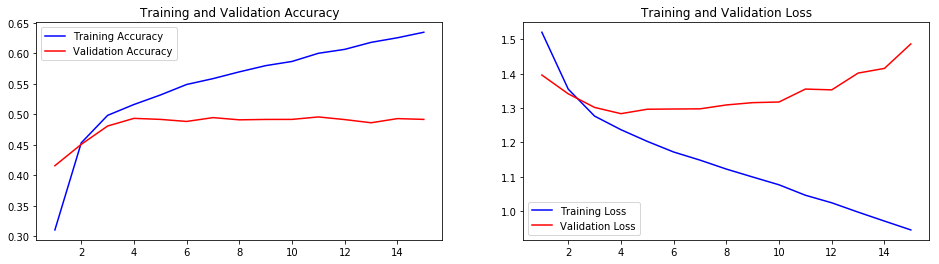

In [0]:
visualise_log_record(log_record)


## LSTM

RNNs are family of neural networks used for processing sequential data. However, simple RNNs are not able to capture the long term dependencies which is a major bottleneck.

LSTM(Long Short Term Memory) is an artificial neural network model which are composed of self loops capable of storing long term dependencies.


In [0]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len)
         )
model.add(LSTM(64))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.55))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 25)            50025     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                23040     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 77,550
Trainable params: 77,550
Non-trainable params: 0
_________________________________________________________________


In [0]:
log_record = model.fit(x_train, y_tr,
                    epochs=15,
                    validation_data=(x_test, y_te),
                    batch_size=16)

Train on 37500 samples, validate on 12500 samples
Epoch 1/15
37500/37500 [==============================] - 83s 2ms/step - loss: 1.5208 - acc: 0.3107 - val_loss: 1.3961 - val_acc: 0.4158
Epoch 2/15
37500/37500 [==============================] - 83s 2ms/step - loss: 1.3551 - acc: 0.4533 - val_loss: 1.3414 - val_acc: 0.4508
Epoch 3/15
37500/37500 [==============================] - 85s 2ms/step - loss: 1.2765 - acc: 0.4983 - val_loss: 1.3018 - val_acc: 0.4808
Epoch 4/15
37500/37500 [==============================] - 83s 2ms/step - loss: 1.2369 - acc: 0.5161 - val_loss: 1.2836 - val_acc: 0.4934
Epoch 5/15
37500/37500 [==============================] - 82s 2ms/step - loss: 1.2028 - acc: 0.5316 - val_loss: 1.2965 - val_acc: 0.4917
Epoch 6/15
37500/37500 [==============================] - 83s 2ms/step - loss: 1.1719 - acc: 0.5489 - val_loss: 1.2972 - val_acc: 0.4883
Epoch 7/15
37500/37500 [==============================] - 81s 2ms/step - loss: 1.1482 - acc: 0.5584 - val_loss: 1.2976 - val_acc

In [0]:
loss, accuracy = model.evaluate(x_train, y_tr)
print("Training Accuracy: {:.6f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_te)
print("Testing Accuracy:  {:.6f}".format(accuracy))

37500/37500 [==============================] - 16s 416us/step
Training Accuracy: 0.667467
12500/12500 [==============================] - 5s 378us/step
Testing Accuracy:  0.491680


In [0]:
predictions_lstm = np.argmax(model.predict(embed_test), axis = 1)

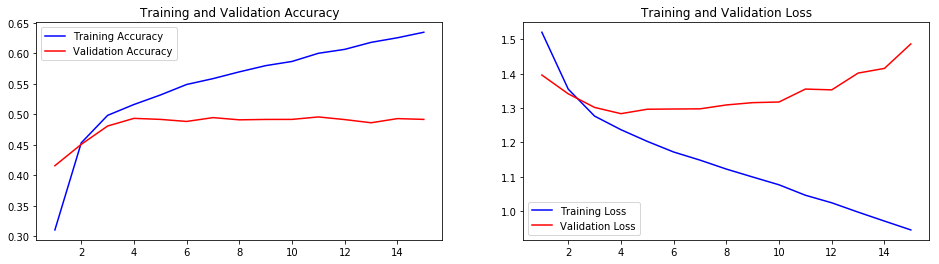

In [0]:
visualise_log_record(log_record)